In [ ]:
import os
import shap
import pickle
import contextlib
import tensorflow           as tf
import numpy                as np
import matplotlib.pyplot    as plt


from labels import class_labels             # imagenette classes

In [4]:
# Load test set for generating explanations
test_dataset = tf.data.Dataset.load('test_dataset')
test_dataset = test_dataset.shuffle(64)

num_classes  = len(class_labels)

def one_hot_encode(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label
    
test_dataset = test_dataset.map(one_hot_encode)

2024-10-19 13:36:29.129001: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## 1. Models with different feature extractors

In [ ]:
# Load models
models   = []

save_dir = "models/diff_extrcs"

for model_file in os.listdir(save_dir):
    if model_file.endswith(".h5"):
        model_path = os.path.join(save_dir, model_file)
        model      = tf.keras.models.load_model(model_path)
        models.append(model)

(64, 224, 224, 3)
(64, 10)
Normalized values:  (0.0, 1.0)


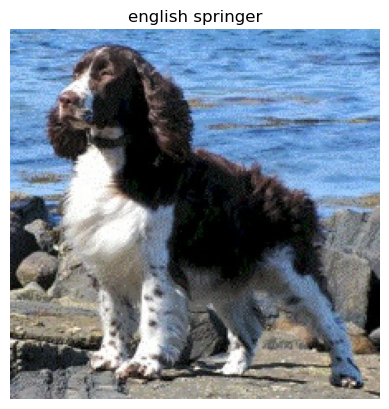

In [5]:
for img_batch, label_batch in test_dataset.take(1):
    print(img_batch.shape)
    print(label_batch.shape)
    img_batch = np.array(img_batch)
    img = img_batch[3]
    print('Normalized values: ', (np.min(img), np.max(img)))
    plt.imshow(img)
    plt.title(class_labels[np.argmax(label_batch[3])])
    plt.axis('off')

In [8]:
for model in models:
    pred = model.predict(tf.reshape(img, (-1,224,224,3)))
    print(f"Predicted by {model.name} as {class_labels[np.argmax(pred)]} with Confidence of: {np.max(pred)*100:.2f}%")

1/1 [==============================] - 0s 76ms/step

Predicted by Xception_imgnette as english springer with Confidence of: 100.00%
1/1 [==============================] - 0s 72ms/step

Predicted by InceptionV3_imgnette as english springer with Confidence of: 100.00%
1/1 [==============================] - 0s 76ms/step

Predicted by DenseNet121_imgnette as english springer with Confidence of: 100.00%
1/1 [==============================] - 0s 67ms/step

Predicted by Res50_imgnette as english springer with Confidence of: 100.00%


In [9]:
# Rescale instance to [0, 255] and convert to uint8
instance         = (img * 255).astype(np.uint8)
instance_batched = np.expand_dims(instance, axis=0)

print(instance.shape)  # Should print (224, 224, 3)
print(instance.dtype)  # Should print uint8
print(type(instance))

(224, 224, 3)
uint8
<class 'numpy.ndarray'>


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:34, 34.02s/it]                                                                    

SHAP vizualization for model : Xception_imgnette


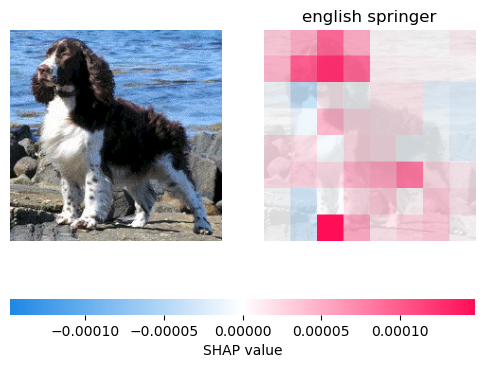

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.02s/it]                                                                    

SHAP vizualization for model : InceptionV3_imgnette


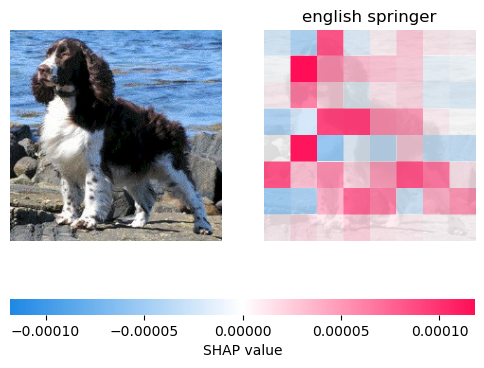

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:33, 33.44s/it]                                                                    

SHAP vizualization for model : DenseNet121_imgnette


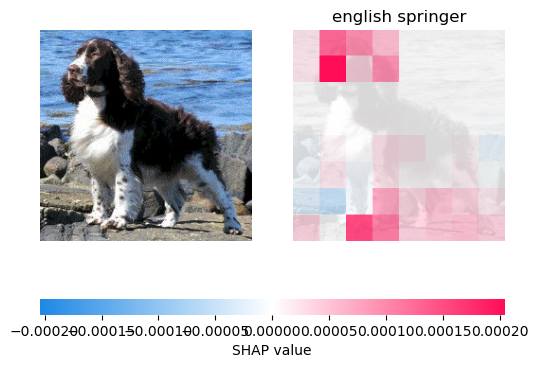

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.51s/it]                                                                    

SHAP vizualization for model : Res50_imgnette


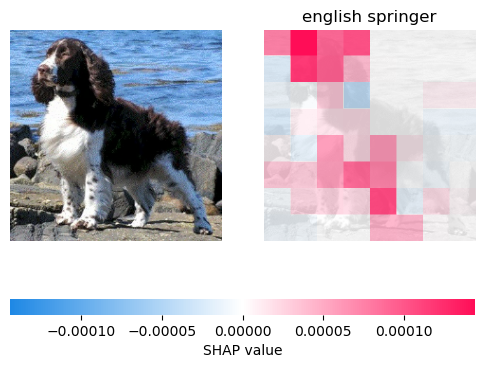

CPU times: user 9min 31s, sys: 33.1 s, total: 10min 4s
Wall time: 2min 12s


In [10]:
%%time
def predict_fn(images, model):
    # Convert images back to float32 in [0, 1] for the model
    images = images.astype(np.float32) / 255.0
    return model.predict(images, verbose=0)

model_shap_values  = {}
masker             = shap.maskers.Image("inpaint_telea", (224,224,3))

for model in models:
    explainer = shap.Explainer(lambda x : predict_fn(x, model), 
                               masker, 
                               output_names = class_labels)
    
    shap_values    = explainer(
        instance_batched, 
        batch_size = 500, 
        max_evals  = 1000, 
        outputs    = shap.Explanation.argsort.flip[:1]) # focus on only top prediction

    model_shap_values[model.name] = shap_values.values[0]
    
    print(F"SHAP vizualization for model : {model.name}")
    shap.image_plot(shap_values)

In [6]:
import helper_functions
from helper_functions import get_sample, get_predictions, filter_correct_predictions

sample_lists = [get_sample(i, test_dataset) for i in range(10)]

In [6]:
# Filter out wrong predictions
predictions  = [get_predictions(models, sample_list) for sample_list in sample_lists]
newlists     = [filter_correct_predictions(prediction) for prediction in predictions]

Wrong Prediction at index 21 by Xception_imgnette: Predicted english springer, True tench
Wrong Prediction at index 13 by Res50_imgnette: Predicted french horn, True english springer
Wrong Prediction at index 4 by DenseNet121_imgnette: Predicted golf ball, True cassette player
Wrong Prediction at index 5 by Xception_imgnette: Predicted gas pump, True cassette player
Wrong Prediction at index 9 by Xception_imgnette: Predicted gas pump, True cassette player
Wrong Prediction at index 37 by InceptionV3_imgnette: Predicted garbage truck, True cassette player
Wrong Prediction at index 43 by DenseNet121_imgnette: Predicted golf ball, True cassette player
Wrong Prediction at index 46 by Xception_imgnette: Predicted chain saw, True cassette player
Wrong Prediction at index 66 by DenseNet121_imgnette: Predicted french horn, True cassette player
Wrong Prediction at index 74 by InceptionV3_imgnette: Predicted chain saw, True cassette player
Wrong Prediction at index 27 by Xception_imgnette: Predic

### Generate SHAP explanations

In [ ]:
from tools import SHAPExplainer

shap_explainer = SHAPExplainer()

In [ ]:
%%time
import SHAP

save_directory = 'SHAP_expls/diff_extrcs'

with open(os.devnull, 'w') as f:
    with contextlib.redirect_stdout(f):
        shap_explainer.generate_and_save_explanations(newlists, models, save_directory)

## 2. Models with different feature extractors

In [ ]:
# Load models of different optimizers (DenseNet + Adam, SGD, RMSprop, Nadam)
models_opt = []

save_dir   = "models/diff_optimizers"

for model_file in os.listdir(save_dir):
    if model_file.endswith(".h5"):
        model_path = os.path.join(save_dir, model_file)
        model      = tf.keras.models.load_model(model_path)
        models_opt.append(model)

In [8]:
for model_file in models_opt:
    print(model_file.name)

DenseNet121_rmsp
DenseNet121_adam
DenseNet121_SGD
DenseNet121_nadam


In [10]:
preds_opt    = [get_predictions(models_opt, sample_list) for sample_list in sample_lists]
newlists_opt = [filter_correct_predictions(prediction) for prediction in preds_opt]

Wrong Prediction at index 13 by DenseNet121_nadam: Predicted chain saw, True english springer
Wrong Prediction at index 12 by DenseNet121_adam: Predicted golf ball, True cassette player
Wrong Prediction at index 35 by DenseNet121_rmsp: Predicted french horn, True cassette player
Wrong Prediction at index 40 by DenseNet121_SGD: Predicted gas pump, True chain saw
Wrong Prediction at index 41 by DenseNet121_rmsp: Predicted french horn, True chain saw
Wrong Prediction at index 55 by DenseNet121_rmsp: Predicted garbage truck, True chain saw
Wrong Prediction at index 33 by DenseNet121_rmsp: Predicted garbage truck, True church
Wrong Prediction at index 8 by DenseNet121_rmsp: Predicted chain saw, True garbage truck
Wrong Prediction at index 41 by DenseNet121_SGD: Predicted church, True garbage truck
Wrong Prediction at index 15 by DenseNet121_rmsp: Predicted golf ball, True gas pump
Wrong Prediction at index 57 by DenseNet121_rmsp: Predicted cassette player, True gas pump
Wrong Prediction at 

### Generate explanations

In [ ]:
%%time
save_directory = 'SHAP_expls/diff_optimizers'

with open(os.devnull, 'w') as f:
    with contextlib.redirect_stdout(f):
        shap_explainer.generate_and_save_explanations(newlists_opt, models_opt, save_directory)

## 3. Models with different weight initialization

In [ ]:
# Load models of different seeds (repeated DenseNet with different random seeds)
model_seeds   = []

save_dir      = "models/diff_seeds/"

for model_file in os.listdir(save_dir):
    if model_file.endswith(".h5"):
        model_path = os.path.join(save_dir, model_file)
        model      = tf.keras.models.load_model(model_path)
        model_seeds.append(model)

In [ ]:
# filter out wrong predictions
preds_seed    = [helper_functions.get_predictions(model_seeds, sample_list) for sample_list in sample_lists]
newlists_seed = [helper_functions.filter_correct_predictions(prediction) for prediction in preds_seed]

### Generate explanations

In [ ]:
%%time
save_directory = 'SHAP_expls/diff_seeds'

with open(os.devnull, 'w') as f:
    with contextlib.redirect_stdout(f):
        shap_explainer.generate_and_save_explanations(newlists_seed, models_seeds, save_directory)